# Home Credit Default Risk – Domain-Focused EDA
This notebook performs a credit-risk-centric EDA to surface anomalies, key risk drivers, and feature engineering ideas aligned with the Home Credit Default Risk competition data.

**Scope**
- Integrity checks (magic numbers, XNA/XAP codes, target imbalance)
- External score signals (EXT_SOURCE_1/2/3)
- Financial health ratios (credit/income, annuity/income, credit/goods)
- Behavioral history (previous applications, bureau, installments)
- Demographic risk factors (age, employment, education, gender)
- Red flags and interaction feature ideas

In [11]:
# Imports & paths
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

DATA_DIR = "./"

# Load core tables
app_train = pd.read_csv(DATA_DIR + "application_train.csv")
app_test = pd.read_csv(DATA_DIR + "application_test.csv")
bureau = pd.read_csv(DATA_DIR + "bureau.csv")
prev = pd.read_csv(DATA_DIR + "previous_application.csv")
inst_pay = pd.read_csv(DATA_DIR + "installments_payments.csv")

# Basic sanity
print(app_train.shape, app_test.shape, bureau.shape, prev.shape, inst_pay.shape)
app_train.head()

(307511, 122) (48744, 121) (1716428, 17) (1670214, 37) (13605401, 8)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,...,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,...,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,"135,000.00","312,682.50","29,686.50","297,000.00",Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.01,-19005,-3039,"-9,833.00",-2437,NaN,1,1,0,1,0,0,Laborers,2.00,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,0.00,2.00,0.00,-617.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,"121,500.00","513,000.00","21,865.50","513,000.00",Unaccompanied,Working,Secondary / se

In [12]:
# Data integrity & magic numbers
magic_number = 365243
days_cols = [c for c in app_train.columns if "DAYS" in c]

anomaly_report = {}
for col in days_cols:
    anomaly_val = (app_train[col] == magic_number).sum()
    if anomaly_val:
        anomaly_report[col] = int(anomaly_val)
        app_train[col] = app_train[col].replace({magic_number: np.nan})
        # Add retired flag where relevant
        app_train[f"{col}_IS_RETIREMENT_FLAG"] = app_train[col].isna()

anomaly_report

{'DAYS_EMPLOYED': 55374}

In [13]:
# XNA/XAP code audit
xna_cols = []
xna_counts = {}
for col in app_train.select_dtypes(include="object"):
    counts = app_train[col].value_counts(dropna=False)
    xna_count = counts.loc[counts.index.isin(["XNA", "XAP"])].sum()
    if xna_count > 0:
        xna_cols.append(col)
        xna_counts[col] = int(xna_count)

xna_report = {
    "columns_with_xna": xna_cols,
    "counts": xna_counts,
    "share_of_rows": {col: (app_train[col].isin(["XNA", "XAP"]).mean()) for col in xna_cols},
}
xna_report

{'columns_with_xna': ['CODE_GENDER', 'ORGANIZATION_TYPE'],
 'counts': {'CODE_GENDER': 4, 'ORGANIZATION_TYPE': 55374},
 'share_of_rows': {'CODE_GENDER': 1.3007664766463638e-05,
  'ORGANIZATION_TYPE': 0.18007160719453938}}

Counts:
 TARGET
0    282686
1     24825
Name: count, dtype: int64
Default ratio: 0.0807


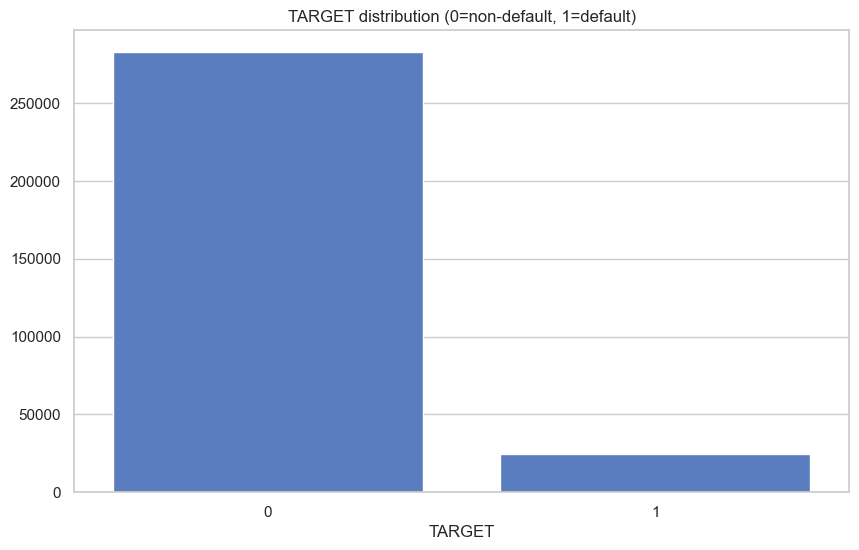

In [14]:
# TARGET imbalance
train_rows = len(app_train)
target_counts = app_train["TARGET"].value_counts()
target_ratio = target_counts.get(1, 0) / target_counts.sum()
print("Counts:\n", target_counts)
print(f"Default ratio: {target_ratio:.4f}")
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title("TARGET distribution (0=non-default, 1=default)")
plt.show()

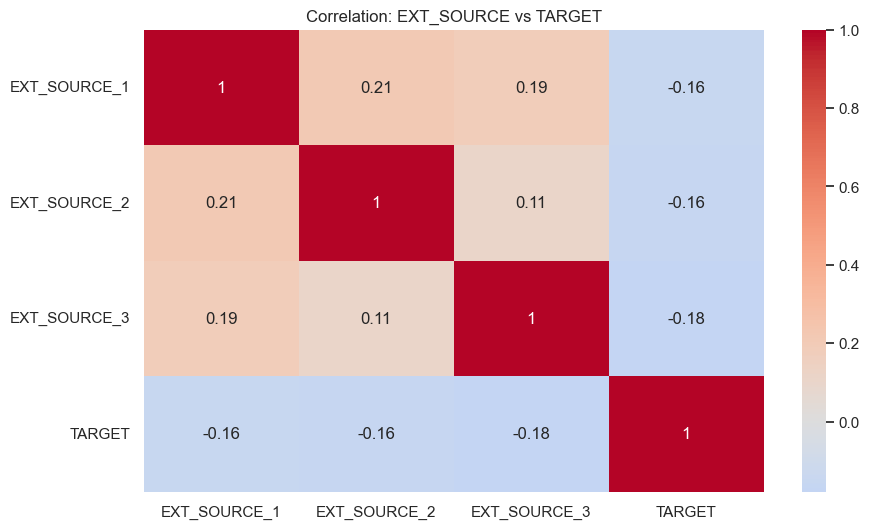

,MISSING_EXT_SOURCE_1,MISSING_EXT_SOURCE_2,MISSING_EXT_SOURCE_3,TARGET
0,0,0,0,0.07
1,0,0,1,0.08
2,0,1,0,0.11
3,0,1,1,0.05
4,1,0,0,0.08
5,1,0,1,0.10
6,1,1,0,0.06
7,1,1,1,0.08


In [15]:
# External sources correlation and missingness
ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
ext_df = app_train[ext_cols + ["TARGET"]]

corr = ext_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation: EXT_SOURCE vs TARGET")
plt.show()

# Missingness impact
missing_flags = app_train[ext_cols].isna().astype(int)
missing_flags.columns = [f"MISSING_{c}" for c in ext_cols]
missing_flags["TARGET"] = app_train["TARGET"]
missing_impact = missing_flags.groupby(list(missing_flags.columns[:-1]))["TARGET"].mean().reset_index()
missing_impact

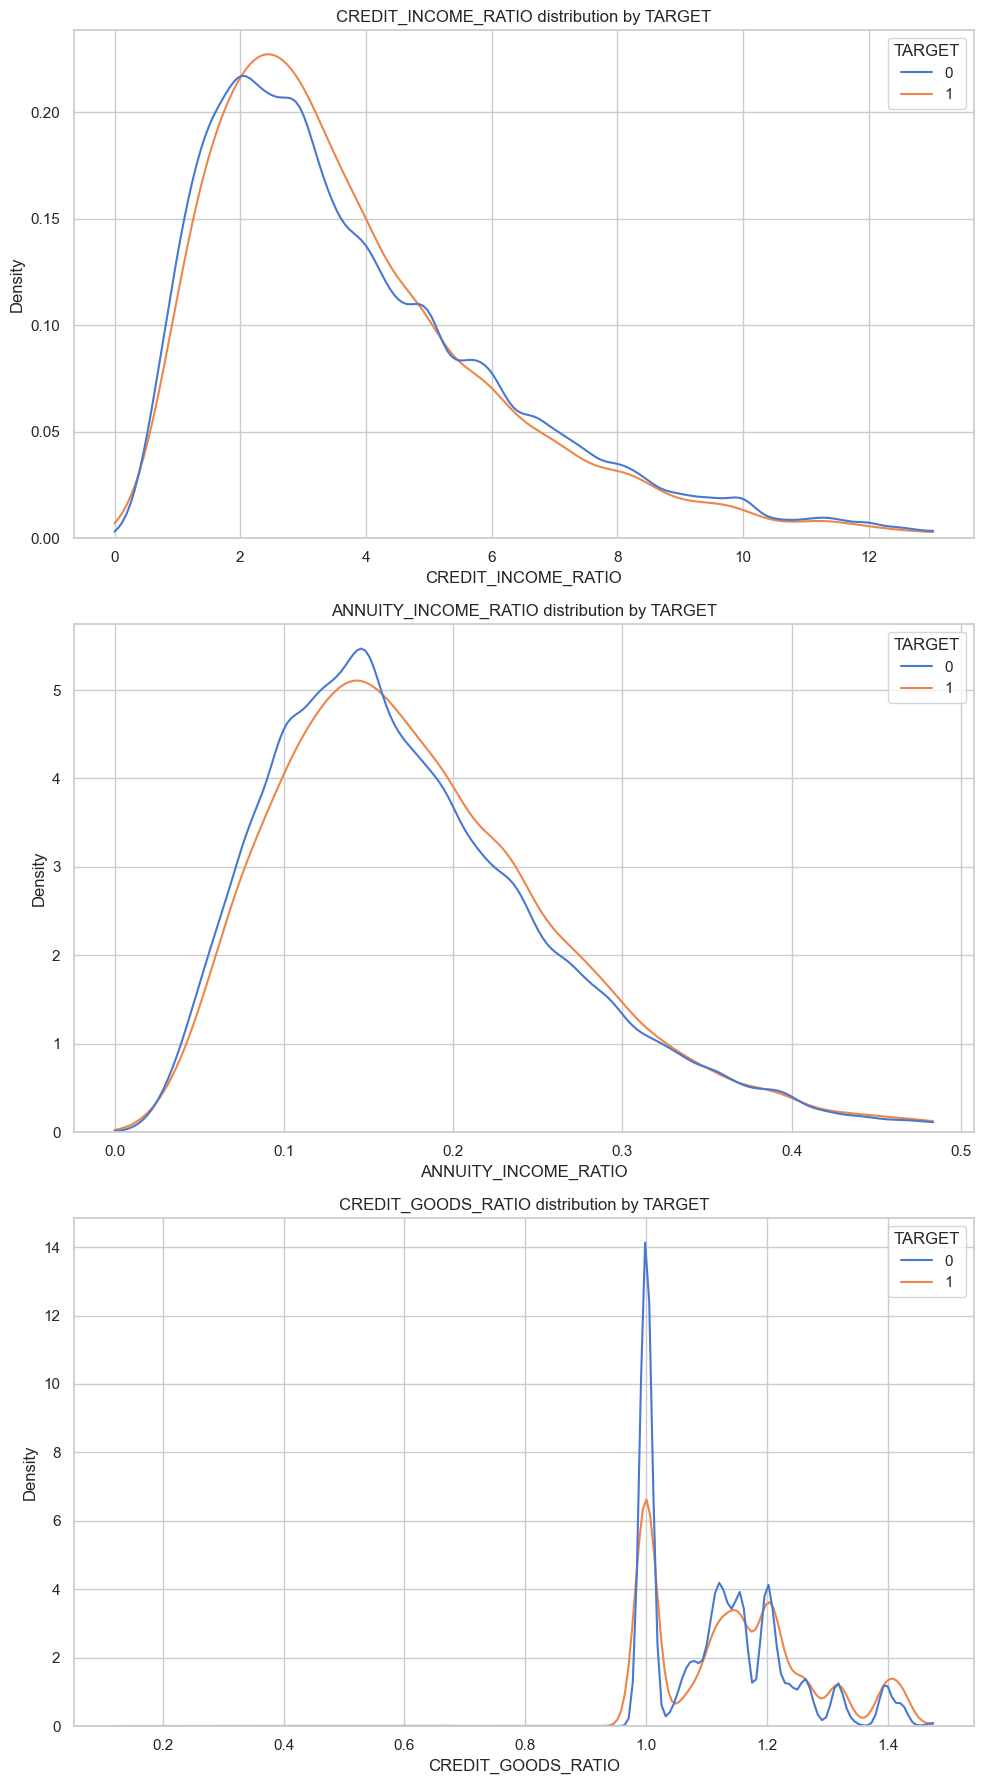

CREDIT_INCOME_RATIO               ANNUITY_INCOME_RATIO                \
                    median mean quantile               median mean quantile   
TARGET                                                                        
0                     3.27 3.96     3.27                 0.16 0.18     0.16   
1                     3.25 3.89     3.25                 0.17 0.19     0.17   

       CREDIT_GOODS_RATIO                
                   median mean quantile  
TARGET                                   
0                    1.12 1.12     1.12  
1                    1.15 1.15     1.15

In [ ]:
# Financial health ratios
app_train["CREDIT_INCOME_RATIO"] = app_train["AMT_CREDIT"] / app_train["AMT_INCOME_TOTAL"]
app_train["ANNUITY_INCOME_RATIO"] = app_train["AMT_ANNUITY"] / app_train["AMT_INCOME_TOTAL"]
app_train["CREDIT_GOODS_RATIO"] = app_train["AMT_CREDIT"] / app_train["AMT_GOODS_PRICE"]

ratio_cols = ["CREDIT_INCOME_RATIO", "ANNUITY_INCOME_RATIO", "CREDIT_GOODS_RATIO"]

fig, axes = plt.subplots(len(ratio_cols), 1, figsize=(10, 18))
for ax, col in zip(axes, ratio_cols):
    sns.kdeplot(data=app_train, x=col, hue="TARGET", common_norm=False, ax=ax, clip=(0, app_train[col].quantile(0.99)))
    ax.set_title(f"{col} distribution by TARGET")
plt.tight_layout()
plt.show()

ratio_summary = app_train[ratio_cols + ["TARGET"]].groupby("TARGET").agg(
    [
        ("mean", "mean"),
        ("median", "median"),
        ("p10", lambda s: s.quantile(0.10)),
        ("p90", lambda s: s.quantile(0.90)),
    ]
)
ratio_summary

In [17]:
# Behavioral history – previous applications
prev_refusal = prev.groupby("NAME_CONTRACT_STATUS").size()

# Link to current target
prev_status = prev.merge(app_train[["SK_ID_CURR", "TARGET"]], on="SK_ID_CURR", how="left")
refusal_rate_by_target = (
    prev_status[prev_status["NAME_CONTRACT_STATUS"] == "Refused"]
    .groupby("TARGET")["NAME_CONTRACT_STATUS"].count()
    / prev_status.groupby("TARGET")["NAME_CONTRACT_STATUS"].count()
)

prev["ASKED_MINUS_GRANTED"] = prev["AMT_APPLICATION"] - prev["AMT_CREDIT"]
ask_vs_grant = prev.merge(app_train[["SK_ID_CURR", "TARGET"]], on="SK_ID_CURR", how="left")
ask_grant_summary = ask_vs_grant.groupby("TARGET")["ASKED_MINUS_GRANTED"].describe(percentiles=[0.1, 0.5, 0.9])

refusal_rate_by_target, ask_grant_summary.head()

(TARGET
 0.00   0.17
 1.00   0.24
 Name: NAME_CONTRACT_STATUS, dtype: float64,
               count       mean       std           min        10%  50%  \
 TARGET                                                                   
 0.00   1,291,341.00 -20,837.04 72,260.66 -1,350,000.00 -69,021.00 0.00   
 1.00     122,359.00 -23,994.96 72,938.92   -900,000.00 -83,160.00 0.00   
 
             90%          max  
 TARGET                        
 0.00   5,643.00 3,020,449.50  
 1.00   2,884.50 2,135,700.00  )

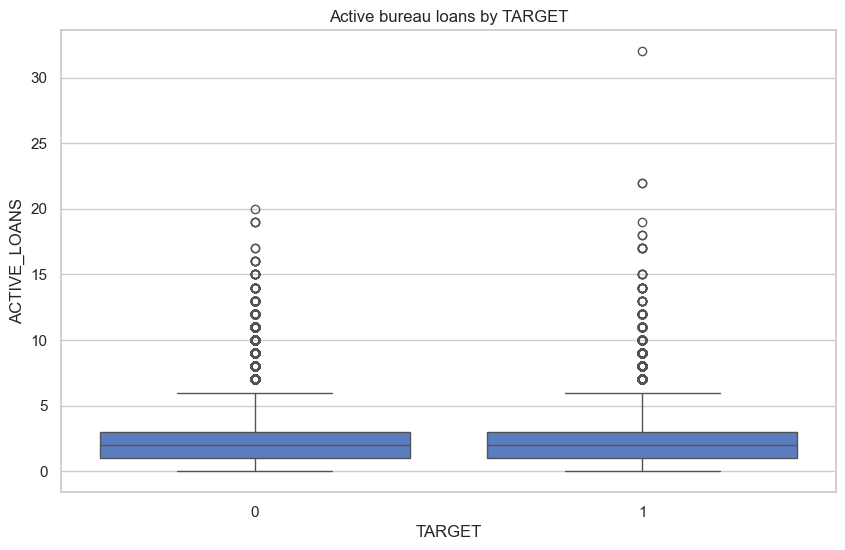

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,count,mean,std,min,10%,50%,90%,max
TARGET,,,,,,,,
0,"242,184.00",NaN,NaN,-inf,0.00,0.20,0.71,inf
1,"20,288.00",NaN,NaN,-inf,0.00,0.35,0.84,inf


In [18]:
# Bureau data – active vs closed & debt burden
bureau_status = bureau.copy()
bureau_status["IS_ACTIVE"] = (bureau_status["CREDIT_ACTIVE"] == "Active").astype(int)
bureau_status["IS_CLOSED"] = (bureau_status["CREDIT_ACTIVE"] == "Closed").astype(int)

bureau_agg = bureau_status.groupby("SK_ID_CURR").agg(
    ACTIVE_LOANS=("IS_ACTIVE", "sum"),
    CLOSED_LOANS=("IS_CLOSED", "sum"),
    TOTAL_CREDIT_SUM=("AMT_CREDIT_SUM", "sum"),
    TOTAL_DEBT_SUM=("AMT_CREDIT_SUM_DEBT", "sum"),
)
bureau_agg["DEBT_BURDEN"] = bureau_agg["TOTAL_DEBT_SUM"] / bureau_agg["TOTAL_CREDIT_SUM"]

bureau_merged = app_train[["SK_ID_CURR", "TARGET"]].merge(bureau_agg, on="SK_ID_CURR", how="left")

sns.boxplot(data=bureau_merged, x="TARGET", y="ACTIVE_LOANS")
plt.title("Active bureau loans by TARGET")
plt.show()

bureau_merged.groupby("TARGET")["DEBT_BURDEN"].describe(percentiles=[0.1, 0.5, 0.9])

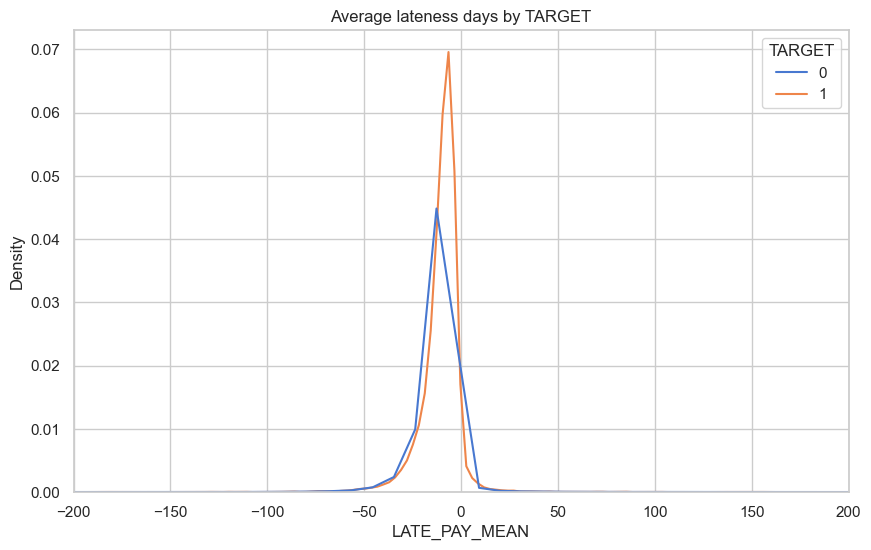

LATE_PAY_PCT                                    UNDERPAY_PCT            \
              count mean  std  min  10%  50%  90%  max        count mean  std   
TARGET                                                                          
0        267,767.00 0.07 0.11 0.00 0.00 0.02 0.23 1.00   267,767.00 0.08 0.15   
1         23,876.00 0.10 0.14 0.00 0.00 0.05 0.30 1.00    23,876.00 0.12 0.18   

                                 
        min  10%  50%  90%  max  
TARGET                           
0      0.00 0.00 0.00 0.29 1.00  
1      0.00 0.00 0.01 0.38 1.00

In [20]:
# Installments payments – timeliness and underpayment
inst_pay["LATE_DAYS"] = inst_pay["DAYS_ENTRY_PAYMENT"] - inst_pay["DAYS_INSTALMENT"]
inst_pay["UNDERPAYMENT"] = inst_pay["AMT_INSTALMENT"] - inst_pay["AMT_PAYMENT"]

inst_agg = inst_pay.groupby("SK_ID_CURR").agg(
    LATE_PAY_MEAN=("LATE_DAYS", "mean"),
    LATE_PAY_PCT=("LATE_DAYS", lambda s: (s > 0).mean()),
    UNDERPAY_MEAN=("UNDERPAYMENT", "mean"),
    UNDERPAY_PCT=("UNDERPAYMENT", lambda s: (s > 0).mean()),
)

inst_merged = app_train[["SK_ID_CURR", "TARGET"]].merge(inst_agg, on="SK_ID_CURR", how="left")

sns.kdeplot(data=inst_merged, x="LATE_PAY_MEAN", hue="TARGET", common_norm=False)
plt.title("Average lateness days by TARGET")
plt.xlim(-200, 200)
plt.show()

inst_merged.groupby("TARGET")[['LATE_PAY_PCT', 'UNDERPAY_PCT']].describe(percentiles=[0.1, 0.5, 0.9])

C:\Users\Admin49\AppData\Local\Temp\ipykernel_16852\131383063.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = app_train.groupby(age_bins)["TARGET"].mean()


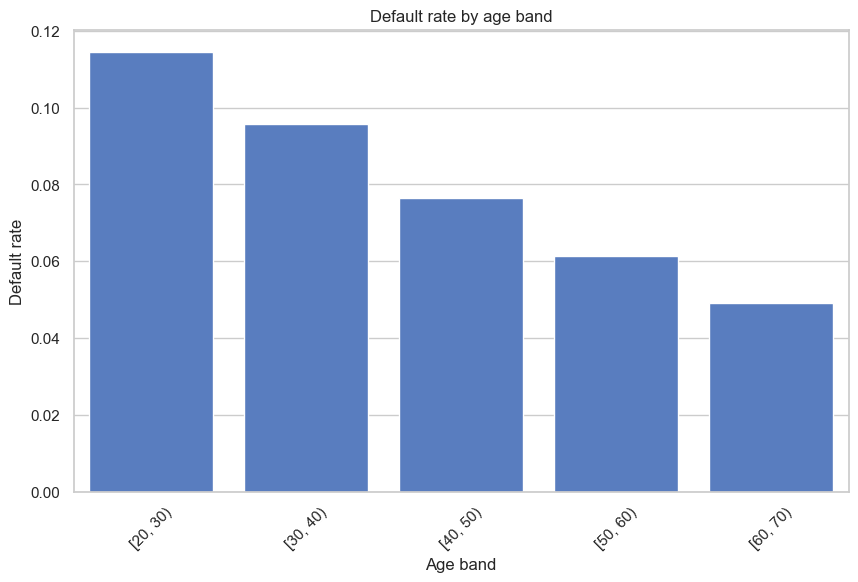

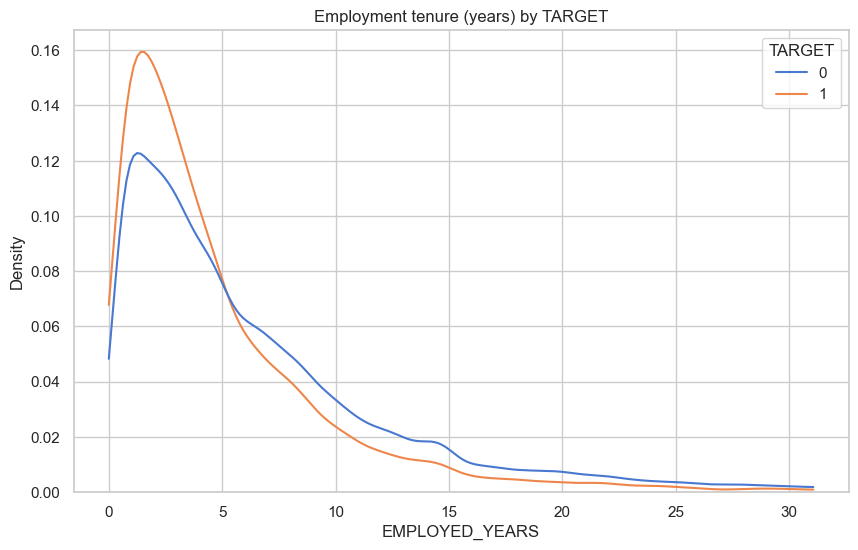

CODE_GENDER,F,M,XNA
NAME_EDUCATION_TYPE,,,
Academic degree,0.03,0.00,NaN
Higher education,0.05,0.06,0.00
Incomplete higher,0.08,0.09,0.00
Lower secondary,0.09,0.13,NaN
Secondary / secondary special,0.08,0.11,0.00


In [21]:
# Demographic risk factors
app_train["AGE_YEARS"] = (-app_train["DAYS_BIRTH"]) / 365
app_train["EMPLOYED_YEARS"] = (-app_train["DAYS_EMPLOYED"]) / 365

# Age bands
age_bins = pd.cut(app_train["AGE_YEARS"], bins=[20, 30, 40, 50, 60, 70], right=False)
age_default = app_train.groupby(age_bins)["TARGET"].mean()

sns.barplot(x=age_default.index.astype(str), y=age_default.values)
plt.title("Default rate by age band")
plt.ylabel("Default rate")
plt.xlabel("Age band")
plt.xticks(rotation=45)
plt.show()

# Employment stability
sns.kdeplot(data=app_train, x="EMPLOYED_YEARS", hue="TARGET", common_norm=False, clip=(0, app_train["EMPLOYED_YEARS"].quantile(0.99)))
plt.title("Employment tenure (years) by TARGET")
plt.show()

# Education and gender pivot
edu_gender_pivot = pd.pivot_table(
    app_train,
    values="TARGET",
    index="NAME_EDUCATION_TYPE",
    columns="CODE_GENDER",
    aggfunc="mean",
)
edu_gender_pivot

In [22]:
# Automated red flags & interaction feature ideas
red_flags = []

# Missing external sources delta
for col in ext_cols:
    miss_rate = app_train.loc[app_train[col].isna(), "TARGET"].mean()
    present_rate = app_train.loc[app_train[col].notna(), "TARGET"].mean()
    delta = miss_rate - present_rate
    red_flags.append({"pattern": f"Missing {col}", "default_uplift": delta})

# High credit-to-income tail
high_ci_cut = app_train["CREDIT_INCOME_RATIO"].quantile(0.95)
high_ci_rate = app_train.loc[app_train["CREDIT_INCOME_RATIO"] >= high_ci_cut, "TARGET"].mean()
overall_rate = app_train["TARGET"].mean()
red_flags.append({"pattern": "Top 5% credit/income", "default_uplift": high_ci_rate - overall_rate})

# Frequent late payers
late_cut = inst_merged["LATE_PAY_PCT"].quantile(0.9)
late_rate = inst_merged.loc[inst_merged["LATE_PAY_PCT"] >= late_cut, "TARGET"].mean()
red_flags.append({"pattern": "Top 10% late-payment frequency", "default_uplift": late_rate - overall_rate})

# Youngest age band
young_rate = app_train.loc[app_train["AGE_YEARS"] < 30, "TARGET"].mean()
red_flags.append({"pattern": "Age < 30", "default_uplift": young_rate - overall_rate})

red_flags_sorted = sorted(red_flags, key=lambda x: x["default_uplift"], reverse=True)
red_flags_sorted[:5]

interaction_features = [
    "AGE_YEARS * CREDIT_INCOME_RATIO",
    "EMPLOYED_YEARS * LATE_PAY_PCT",
    "MISSING_EXT_SOURCE_1 * CREDIT_INCOME_RATIO",
]

print("Top red-flag patterns (uplift vs overall default rate):")
for item in red_flags_sorted[:5]:
    print(f"- {item['pattern']}: +{item['default_uplift']:.3f}")

print("\nInteraction feature ideas:")
for feat in interaction_features:
    print(f"- {feat}")

Top red-flag patterns (uplift vs overall default rate):
- Top 10% late-payment frequency: +0.045
- Age < 30: +0.034
- Missing EXT_SOURCE_3: +0.015
- Missing EXT_SOURCE_1: +0.010
- Missing EXT_SOURCE_2: +-0.002

Interaction feature ideas:
- AGE_YEARS * CREDIT_INCOME_RATIO
- EMPLOYED_YEARS * LATE_PAY_PCT
- MISSING_EXT_SOURCE_1 * CREDIT_INCOME_RATIO


In [23]:
# Summary: top red flags, interaction ideas, suspicious segments
import pandas as pd

# Top 5 red flags table
red_flags_df = pd.DataFrame(red_flags_sorted).sort_values("default_uplift", ascending=False).head(5)
print("Top 5 red-flag patterns (uplift vs overall default rate):")
display(red_flags_df)

print("\nInteraction feature ideas:")
for feat in interaction_features:
    print(f"- {feat}")

segments = []

# Segment 1: Missing EXT_SOURCE_1 and high credit/income
top_ci_mask = app_train["CREDIT_INCOME_RATIO"] >= high_ci_cut
mask_seg1 = app_train["EXT_SOURCE_1"].isna() & top_ci_mask
if mask_seg1.any():
    segments.append({
        "segment": "Missing EXT_SOURCE_1 & top 5% credit/income",
        "count": int(mask_seg1.sum()),
        "default_rate": app_train.loc[mask_seg1, "TARGET"].mean(),
    })

# Segment 2: Top 10% late-payment frequency
mask_seg2 = inst_merged["LATE_PAY_PCT"] >= late_cut
if mask_seg2.any():
    segments.append({
        "segment": "Top 10% late-payment frequency",
        "count": int(mask_seg2.sum()),
        "default_rate": inst_merged.loc[mask_seg2, "TARGET"].mean(),
    })

# Segment 3: Young & high credit/income tail
mask_seg3 = (app_train["AGE_YEARS"] < 30) & top_ci_mask
if mask_seg3.any():
    segments.append({
        "segment": "Age < 30 & top 5% credit/income",
        "count": int(mask_seg3.sum()),
        "default_rate": app_train.loc[mask_seg3, "TARGET"].mean(),
    })

# Segment 4: Retirement/unemployment flag if present
ret_flag_col = "DAYS_EMPLOYED_IS_RETIREMENT_FLAG"
if ret_flag_col in app_train.columns:
    mask_seg4 = app_train[ret_flag_col] & (app_train["CREDIT_INCOME_RATIO"] >= app_train["CREDIT_INCOME_RATIO"].quantile(0.75))
    if mask_seg4.any():
        segments.append({
            "segment": "Retirement flag & high credit/income (75p+)",
            "count": int(mask_seg4.sum()),
            "default_rate": app_train.loc[mask_seg4, "TARGET"].mean(),
        })

segments_df = pd.DataFrame(segments)
print("\nSuspicious segments (default rates):")
display(segments_df)

Top 5 red-flag patterns (uplift vs overall default rate):


,pattern,default_uplift
0,Top 10% late-payment frequency,0.05
1,Age < 30,0.03
2,Missing EXT_SOURCE_3,0.02
3,Missing EXT_SOURCE_1,0.01
4,Missing EXT_SOURCE_2,-0.00



Interaction feature ideas:
- AGE_YEARS * CREDIT_INCOME_RATIO
- EMPLOYED_YEARS * LATE_PAY_PCT
- MISSING_EXT_SOURCE_1 * CREDIT_INCOME_RATIO

Suspicious segments (default rates):


,segment,count,default_rate
0,Missing EXT_SOURCE_1 & top 5% credit/income,9210,0.07
1,Top 10% late-payment frequency,29395,0.13
2,Age < 30 & top 5% credit/income,1071,0.09
3,Retirement flag & high credit/income (75p+),16711,0.06


In [24]:
# Sankey: previous application status -> current default outcome
import plotly.graph_objects as go

# Focus on Refused vs Approved flows
prev_status_simple = prev_status.copy()
prev_status_simple = prev_status_simple[prev_status_simple["NAME_CONTRACT_STATUS"].isin(["Refused", "Approved"])]
prev_status_simple["TARGET_LABEL"] = prev_status_simple["TARGET"].map({0: "Non-Default", 1: "Default"})

flow = prev_status_simple.groupby(["NAME_CONTRACT_STATUS", "TARGET_LABEL"]).size().reset_index(name="count")

sources = flow["NAME_CONTRACT_STATUS"].tolist()
targets = flow["TARGET_LABEL"].tolist()
labels = list(pd.unique(sources + targets))
label_index = {label: i for i, label in enumerate(labels)}

source_idxs = [label_index[s] for s in sources]
target_idxs = [label_index[t] for t in targets]
values = flow["count"].tolist()

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(label=labels, pad=20, thickness=20, line=dict(color="black", width=0.5)),
    link=dict(source=source_idxs, target=target_idxs, value=values, color="rgba(99, 110, 250, 0.4)"),
)])

fig.update_layout(title_text="Flow: Previous Application Status → Current Default Outcome", font_size=12)
fig.show()

C:\Users\Admin49\AppData\Local\Temp\ipykernel_16852\2856718385.py:13: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = list(pd.unique(sources + targets))
